In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy
import torch.utils.data as data
import h5py


In [4]:
file = 'ASLdatasetGroup23.hdf5'
with h5py.File(file, 'r') as rd:
    x_train = np.array(rd['x_train'])
    y_train = np.array(rd['y_train'])
    x_test = np.array(rd['x_test'])
    y_test = np.array(rd['y_test'])

XT = np.copy(x_train)
XT = XT.astype('float32')/255

XTE = np.copy(x_test)
XTE = XTE.astype('float32')/255

class_enum = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
print(XT.shape)
print(y_train.shape)
print(XTE.shape)
print(y_test.shape)

class ASLSet(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        'Initialization'
        self.labels = labels
        self.images = images
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'
        img = self.images[index]
        lab = self.labels[index]
        X = torch.from_numpy(img)
        Y = lab
        
        return X, Y

train_set = ASLSet(XT,y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)

test_set = ASLSet(XTE, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 100, shuffle = False)

loss_func = nn.CrossEntropyLoss()


(99300, 3, 125, 125)
(99300,)
(1450, 3, 125, 125)
(1450,)


In [5]:
# GPU usage for MAC with M1/M2 chip
device = torch.device('mps' if torch.has_mps else 'cpu')


In [8]:
net = models.resnet18()
net = net.to(device)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.05, momentum = 0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim = 1)
    return torch.sum(pred == labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.to(device)


In [17]:
n_epochs = 10
print_every = 10
test_loss_min = np.Inf
test_loss = []
test_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim = 1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\nTrain-loss: {np.mean(train_loss):.4f}, Train-accuracy: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim = 1)
            correct_t += torch.sum(pred_t == target_t).item()
            total_t += target_t.size(0)
        test_acc.append(100 * correct_t/total_t)
        test_loss.append(batch_loss/len(test_loader))
        network_learned = batch_loss < test_loss_min
        print(f'Test loss: {np.mean(test_loss):.4f}, Test accuracy: {(100 * correct_t/total_t):.4f}\n')

        if network_learned:
            test_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
    net.train()


Epoch 1

Epoch [1/10], Step [0/993], Loss: 5.0641
Epoch [1/10], Step [20/993], Loss: 0.1454
Epoch [1/10], Step [40/993], Loss: 0.0471
Epoch [1/10], Step [60/993], Loss: 0.0377
Epoch [1/10], Step [80/993], Loss: 0.0183
Epoch [1/10], Step [100/993], Loss: 0.0282
Epoch [1/10], Step [120/993], Loss: 0.0104
Epoch [1/10], Step [140/993], Loss: 0.0098
Epoch [1/10], Step [160/993], Loss: 0.0098
Epoch [1/10], Step [180/993], Loss: 0.0089
Epoch [1/10], Step [200/993], Loss: 0.0078
Epoch [1/10], Step [220/993], Loss: 0.0082
Epoch [1/10], Step [240/993], Loss: 0.0060
Epoch [1/10], Step [260/993], Loss: 0.0076
Epoch [1/10], Step [280/993], Loss: 0.0081
Epoch [1/10], Step [300/993], Loss: 0.0071
Epoch [1/10], Step [320/993], Loss: 0.0061
Epoch [1/10], Step [340/993], Loss: 0.0060
Epoch [1/10], Step [360/993], Loss: 0.0051
Epoch [1/10], Step [380/993], Loss: 0.0075
Epoch [1/10], Step [400/993], Loss: 0.0051
Epoch [1/10], Step [420/993], Loss: 0.0048
Epoch [1/10], Step [440/993], Loss: 0.0036
Epoch [1

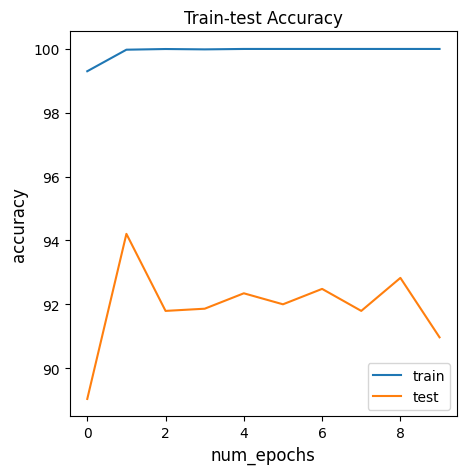

In [18]:
fig = plt.figure(figsize = (5, 5))
plt.title("Train-test Accuracy")
plt.plot(train_acc, label = 'train')
plt.plot(test_acc, label = 'test')
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)
plt.legend(loc = 'best')


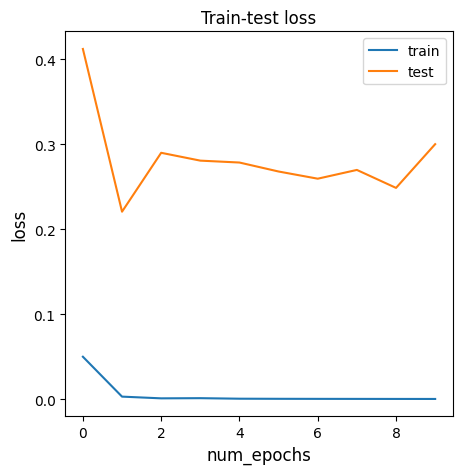

In [21]:
fig = plt.figure(figsize = (5, 5))
plt.title("Train-test loss")
plt.plot(train_loss, label = 'train')
plt.plot(test_loss, label = 'test')
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('loss', fontsize = 12)
plt.legend(loc = 'best')
